In [15]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path

import ccxt
import matplotlib.pyplot as plt
import sys
sys.path.append("..") 
from tp_config import *
from portfolio_tools import load_data_for_portfolio, calc_frontier, calc_weights
from tp_utils.data_provider import read_prices, read_data, load_data_from_exchange

In [11]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns, objective_functions

In [12]:
def calc_frontier(df_period, risk_method, ret_method = "mean_historical_return", span = 180):

    if ret_method == "ema_historical_return":
        mu = expected_returns.return_model(df_period, method=ret_method, span = span)
    else:
        mu = expected_returns.return_model(df_period, method=ret_method)
  
    cov_mat = risk_models.risk_matrix(df_period, method=risk_method)        
    ef = EfficientFrontier(mu, cov_mat)
    return ef


def calc_weights(ef, opt_type, par, verbose = False):

    if opt_type == 'max_sharpe':
        try:
            weights = ef.max_sharpe()
        except:
            if verbose:
                print("Non-convex optimize!")
            weights = ef.nonconvex_objective(
            objective_functions.sharpe_ratio,
            objective_args=(ef.expected_returns, ef.cov_matrix),
            weights_sum_to_one=True,
        )  
    elif opt_type == 'efficient_risk':
        weights = ef.efficient_risk(par) 

    ef.portfolio_performance(verbose=verbose)
    cleaned_weights = ef.clean_weights(cutoff=0.001)
    dfw = weights_to_df(cleaned_weights)
    dfw['W'] = dfw['W']/dfw['W'].sum()
    return dfw


def weights_to_df(cleaned_weights):
    dfw = pd.DataFrame.from_dict([cleaned_weights]).transpose()
    dfw.columns = ['W']
    dfw = dfw[dfw['W'] > 0]
    return dfw

def final_sums(df, total):
    xx = round(df * total, -1)
    xx = xx[xx['W'] > 0]
    xx = xx.sort_values("W")
    return xx

In [36]:
data_path = DATA_PATH_CRYPTO

pair = 'USDT'
#pair = 'BTC'

main_assets = [ 'BNB', 'THETA', 'RUNE', 'TFUEL', 'LINK', 'SOL', 'MATIC']
main_assets = [ 'BNB', 'AUDIO', 'RUNE', 'CTSI',  'TVK', 'POA', 'LUNA', 'TLM']
#index_assets = pd.read_csv('index_assets.csv')['asset'].tolist()
#index_low_assets = pd.read_csv('index_low_assets.csv')['asset'].tolist()
assets = ['ADA', 'BNB', 'SOL', 'FTT', 'TRX', 'ZIL', 'NEON', 'AVAX', 'WLD', 'PEPE', 'NEAR', 'ETH', 'BONK', 'WAVES',
              'FTM', 'MATIC', 'INJ', 'JUP', 'THETA', 'GALA',  'RUNE', 'RAIN', 'LUNA']

#assets = index_assets + index_low_assets
markets = [m + '-' + pair for m in assets]
if pair  == 'USDT':
    markets = ['BTC-USDT'] + markets

In [37]:
exchange = ccxt.bybit()
start_timestamp = exchange.parse8601('2023-04-01 00:00:00')
timeframes = {'4h':240}

data_path = DATA_PATH_CRYPTO + '/' + pair
load_data_from_exchange(exchange, markets, timeframes, start_timestamp, data_path, 10)

1680307200000 2023-04-01 04:00:00
BTC-USDT
4h
2024-03-18 08:00:00
ADA-USDT
4h
2024-03-18 08:00:00
BNB-USDT
4h
2024-03-18 08:00:00
SOL-USDT
4h
2024-03-18 08:00:00
FTT-USDT
4h
2024-03-18 08:00:00
TRX-USDT
4h
2024-03-18 08:00:00
ZIL-USDT
4h
2024-03-18 08:00:00
NEON-USDT
4h
2024-03-18 08:00:00
AVAX-USDT
4h
2024-03-18 08:00:00
WLD-USDT
4h
2024-03-18 08:00:00
PEPE-USDT
4h
2024-03-18 08:00:00
NEAR-USDT
4h
2024-03-18 08:00:00
ETH-USDT
4h
2024-03-18 08:00:00
BONK-USDT
4h
2024-03-18 08:00:00
WAVES-USDT
4h
2024-03-18 08:00:00
FTM-USDT
4h
2024-03-18 08:00:00
MATIC-USDT
4h
2024-03-18 08:00:00
INJ-USDT
4h
2024-03-18 08:00:00
JUP-USDT
4h
Ошибка чтения 1  из  10
Ошибка чтения 2  из  10
Ошибка чтения 3  из  10
Ошибка чтения 4  из  10
Ошибка чтения 5  из  10
Ошибка чтения 6  из  10
Ошибка чтения 7  из  10
Ошибка чтения 8  из  10
Ошибка чтения 9  из  10
Нет данных
THETA-USDT
4h
2024-03-18 08:00:00
GALA-USDT
4h
2024-03-18 08:00:00
RUNE-USDT
4h
2024-03-18 08:00:00
RAIN-USDT
4h
2024-03-18 08:00:00
LUNA-USDT

In [38]:
df_all =  load_data_for_portfolio(markets, '4h')   
print(datetime.fromtimestamp(df_all.index[0]/1000))
print(datetime.fromtimestamp(df_all.index[-1]/1000))

BTC-USDT
ADA-USDT
BNB-USDT
SOL-USDT
FTT-USDT
TRX-USDT
ZIL-USDT
NEON-USDT
AVAX-USDT
WLD-USDT
PEPE-USDT
NEAR-USDT
ETH-USDT
BONK-USDT
WAVES-USDT
FTM-USDT
MATIC-USDT
INJ-USDT
JUP-USDT
JUP-USDT Нет данных
THETA-USDT
GALA-USDT
RUNE-USDT
RAIN-USDT
LUNA-USDT
2023-10-01 04:00:00
2024-03-18 08:00:00


In [39]:
dfp = df_all
ef = calc_frontier(dfp, "ledoit_wolf",  "ema_historical_return", span = 90)
dfw = calc_weights(ef, 'max_sharpe', 0, verbose = True)    

OrderedDict([('BTC-USDT', 0.0), ('ADA-USDT', 0.0), ('BNB-USDT', 0.0), ('SOL-USDT', 0.2710700702184537), ('FTT-USDT', 0.0), ('TRX-USDT', 0.0), ('ZIL-USDT', 0.0), ('NEON-USDT', 0.0), ('AVAX-USDT', 0.0), ('WLD-USDT', 0.0), ('PEPE-USDT', 0.0), ('NEAR-USDT', 0.3242382962375062), ('ETH-USDT', 0.0), ('BONK-USDT', 0.0), ('WAVES-USDT', 0.0), ('FTM-USDT', 0.0), ('MATIC-USDT', 0.0), ('INJ-USDT', 0.0), ('THETA-USDT', 0.0), ('GALA-USDT', 0.0), ('RUNE-USDT', 0.0), ('RAIN-USDT', 0.40469163354404), ('LUNA-USDT', 0.0)])
Expected annual return: 1102.0%
Annual volatility: 45.8%
Sharpe Ratio: 24.04


In [19]:
dfw.to_dict()

{'W': {'BNB-USDT': 0.5702400000000001,
  'SOL-USDT': 0.19580000000000003,
  'PEPE-USDT': 0.017860000000000004,
  'FTM-USDT': 0.21610000000000001}}

### Rebalancing

In [20]:
import pybroker as pyb
from datetime import datetime
from pybroker import ExecContext, Strategy, StrategyConfig, FeeMode

pyb.enable_data_source_cache('rebalancing')

In [24]:
def periods(dt: datetime) -> bool:
    x = pyb.param('count_periods') 
    if x == 4:
        pyb.param('count_periods', 0)
        return True
    else: 
        x += 1
        pyb.param('count_periods', x) 
    return False

def start_of_week(dt: datetime) -> bool:
    if dt.weekday() == 0:
        return True
    return False

def set_target_shares(
    ctxs: dict[str, ExecContext],
    targets: dict[str, float]
):
    for symbol, target in targets.items():
        ctx = ctxs[symbol]
        target_shares = ctx.calc_target_shares(target)
        pos = ctx.long_pos()
        if pos is None:
            ctx.buy_shares = target_shares
        elif pos.shares < target_shares:
            ctx.buy_shares = target_shares - pos.shares
        elif pos.shares > target_shares:
            ctx.sell_shares = pos.shares - target_shares 

In [25]:
import riskfolio as rp

pyb.param('lookback', 90)  # Use past year of returns.

def calculate_returns(ctxs: dict[str, ExecContext], lookback: int):
    prices = {}
    for ctx in ctxs.values():
        prices[ctx.symbol] = ctx.close[-lookback:]
    df = pd.DataFrame(prices)
    return df.pct_change().dropna()

def optimization(ctxs: dict[str, ExecContext]):
    lookback = pyb.param('lookback')
    first_ctx = tuple(ctxs.values())[0]
    if start_of_week(first_ctx.dt):
        Y = calculate_returns(ctxs, lookback)
        port = rp.Portfolio(returns=Y)
        port.assets_stats(method_mu='hist', method_cov='hist', d=0.94)
        w = port.optimization(
            model='Classic',
            rm='CVaR',
            obj='MinRisk',
            rf=0,      # Risk free rate.
            l=0,       # Risk aversion factor.
            hist=True  # Use historical scenarios.
        )
        targets = {
            symbol: w.T[symbol].values[0]
            for symbol in ctxs.keys()
        }
        set_target_shares(ctxs, targets)

In [26]:

pyb.param('lookback', 90)  # Use past year of returns.

def to_dfp(ctxs: dict[str, ExecContext], lookback: int):
    prices = {}
    for ctx in ctxs.values():
        prices[ctx.symbol] = ctx.close[-lookback:]
    df = pd.DataFrame(prices)
    return df

def optimization(ctxs: dict[str, ExecContext]):
    lookback = pyb.param('lookback')
    first_ctx = tuple(ctxs.values())[0]
    if start_of_week(first_ctx.dt):
        dfp = to_dfp(ctxs, lookback) 
        ef = calc_frontier(dfp, "ledoit_wolf",  "ema_historical_return", span = 90)
        dfw = calc_weights(ef, 'max_sharpe', 0, verbose = True) 
        targets = dfw.to_dict()["W"]
        print(targets)
        set_target_shares(ctxs, targets)

In [27]:
fee = FeeMode('order_percent')
config = StrategyConfig(fee_mode = fee, fee_amount = 0.05)

In [29]:
strategy = Strategy(dfp, start_date='1/1/2023', end_date='7/3/2024', config = config)

assets = ['DSKY', 'CHMF', 'BANEP', 'SBER']
assets = dfp.columns.values
drops = ["GTRK", "SFIN", "ORUP", "UWGN", "RKKE", "KROT", "APTK", "VEON-RX"]
assets = [x for x in assets if x not in drops]
strategy.add_execution(None, assets)


ValueError: DataFrame is missing required columns: ['symbol', 'date', 'open', 'high', 'low', 'close']

In [122]:
strategy.set_after_exec(optimization)
result = strategy.backtest(warmup=pyb.param('lookback'))

Backtesting: 2023-01-01 00:00:00 to 2024-07-03 00:00:00

Test split: 2023-01-03 00:00:00 to 2024-03-07 00:00:00


 30% (91 of 300) |######                 | Elapsed Time: 0:00:00 ETA:   0:00:00

Expected annual return: 172124.0%
Annual volatility: 81.4%
Sharpe Ratio: 2113.25
{'VSMO': 0.008070000000000003, 'SVAV': 0.8623500000000001, 'LNZL': 0.028210000000000002, 'NKHP': 0.011690000000000002, 'LSNG': 0.044160000000000005, 'LNZLP': 0.009250000000000001, 'AMEZ': 0.036270000000000004}
Expected annual return: 19499.5%
Annual volatility: 36.8%
Sharpe Ratio: 530.33
{'ENPG': 0.003414069187773805, 'NKNCP': 0.002155194118535676, 'IRKT': 0.0021149101163200562, 'MRKV': 0.002124981116873961, 'VSMO': 0.003816909209930006, 'UNAC': 0.002437182134045017, 'TTLK': 0.0011581650636990784, 'CNTL': 0.0036154891988519054, 'MGNT': 0.0018429931013646205, 'SVAV': 0.23703106903670879, 'SPBE': 0.0025278211390301624, 'ETLN': 0.0016315020897326147, 'KZOSP': 0.0018329221008107153, 'KMAZ': 0.0018127800997029052, 'FIXP': 0.0016315020897326147, 'PHOR': 0.001359585074777179, 'HHRU': 0.001792638098595095, 'LNZL': 0.002920590160632458, 'ELFV': 0.003061584168387129, 'SELG': 0.0015207210836396595, 'AGRO': 0.00223576

 33% (101 of 300) |#######               | Elapsed Time: 0:00:00 ETA:   0:00:00

Expected annual return: 7957.9%
Annual volatility: 34.7%
Sharpe Ratio: 229.11
{'VSMO': 0.002248277021348126, 'CNTL': 0.0011136325432845855, 'SVAV': 0.20389981509497396, 'KZOSP': 0.001281728021516221, 'BANE': 0.11219322575222726, 'SBER': 0.02008740964868045, 'BANEP': 0.1710686670028576, 'ABIO': 0.001607413010590015, 'SBERP': 0.008919566313666161, 'TGKN': 0.372005799293999, 'LSNG': 0.03321986888552698, 'KLSB': 0.003340897629853757, 'RNFT': 0.0012502101193477895, 'NSVZ': 0.00132375189107413, 'LNZLP': 0.005221465792570179, 'FESH': 0.03164397377710539, 'LIFE': 0.0012081862497898806, 'AMEZ': 0.027031854093124894, 'CNTLP': 0.0013342578584636074}


 37% (111 of 300) |########              | Elapsed Time: 0:00:00 ETA:   0:00:01

Expected annual return: 8294.1%
Annual volatility: 33.4%
Sharpe Ratio: 247.98
{'CNTL': 0.0011015642211940958, 'SVAV': 0.0705945299468102, 'PRFN': 0.0010700909577314073, 'BANE': 0.14051763027308303, 'BANEP': 0.23151732603153624, 'FLOT': 0.016334623737135307, 'MSTT': 0.006598894239343678, 'MTLR': 0.0010910731333731995, 'ABIO': 0.0016995562269851762, 'TGKN': 0.42378749252509995, 'LSNG': 0.031242459530628736, 'TGKB': 0.0012169661872239535, 'KLSB': 0.009368541424060262, 'NSVZ': 0.0013533503288956034, 'FESH': 0.02270271404441927, 'VRSB': 0.010470105645254357, 'LIFE': 0.001258930538507538, 'AMEZ': 0.023961644582926805, 'TGKBP': 0.0015212077340299418, 'CNTLP': 0.0014582612071045648, 'MTLRP': 0.0011330374846567843}
Expected annual return: 3444.6%
Annual volatility: 28.4%
Sharpe Ratio: 121.29
{'VSMO': 0.007339926600733992, 'SVAV': 0.1771882281177188, 'BANE': 0.08113918860811392, 'NKHP': 0.007869921300786991, 'BANEP': 0.15838841611583884, 'TGKN': 0.17575824241757582, 'KLSB': 0.01695983040169598, 

 40% (121 of 300) |########              | Elapsed Time: 0:00:00 ETA:   0:00:01

Expected annual return: 2915.3%
Annual volatility: 28.5%
Sharpe Ratio: 102.22
{'SVAV': 0.12360123601236013, 'PHOR': 0.006920069200692007, 'BANE': 0.15939159391593918, 'NKHP': 0.25700257002570026, 'BANEP': 0.12788127881278813, 'TGKN': 0.0937909379093791, 'LNZLP': 0.033460334603346034, 'FESH': 0.005730057300573006, 'VRSB': 0.01660016600166002, 'TRMK': 0.17562175621756218}
Expected annual return: 3158.4%
Annual volatility: 28.0%
Sharpe Ratio: 112.53
{'SVAV': 0.10950890491095087, 'PHOR': 0.04925950740492595, 'BANE': 0.10992890071099289, 'NKHP': 0.2863471365286347, 'SBER': 0.00936990630093699, 'BANEP': 0.1044889551104489, 'SBERP': 0.025629743702562973, 'TGKN': 0.11561884381156187, 'LSNG': 0.023079769202307976, 'RENI': 0.05872941270587294, 'QIWI': 0.012949870501294985, 'NLMK': 0.003919960800391996, 'TRMK': 0.09116908830911691}


 43% (131 of 300) |#########             | Elapsed Time: 0:00:01 ETA:   0:00:01

Expected annual return: 1880.9%
Annual volatility: 27.7%
Sharpe Ratio: 67.91
{'SVAV': 0.11489577008702692, 'PHOR': 0.04273426431896377, 'BANE': 0.06416717263711799, 'NKHP': 0.25258044930176077, 'SBER': 0.008773527625986642, 'SBERP': 0.03676381299332119, 'TGKN': 0.1421169803683465, 'LSNG': 0.03539769277474195, 'RENI': 0.12175672940700263, 'NLMK': 0.06572556162720097, 'FESH': 0.014693381906496661, 'LSNGP': 0.00979558793766444, 'TRMK': 0.06641368144100385, 'MRKU': 0.02418538757336572}
Expected annual return: 32496.7%
Annual volatility: 51.5%
Sharpe Ratio: 630.81
{'DSKY': 0.003969693305928344, 'ENPG': 0.002690122113408294, 'NKNCP': 0.004443235400797969, 'IRKT': 0.003425623665014307, 'VSMO': 0.0030931366622335065, 'UNAC': 0.002035223471567324, 'TTLK': 0.004302180308709145, 'MGNT': 0.004009994760810865, 'SVAV': 0.02817071696288236, 'SPBE': 0.0019243944706403902, 'RTKMP': 0.0020049973804054325, 'KZOSP': 0.002942006206424052, 'KMAZ': 0.0012594204650787895, 'KZOS': 0.002599443839922621, 'FIXP':

 47% (141 of 300) |##########            | Elapsed Time: 0:00:01 ETA:   0:00:01

{'ENPG': 0.0060099163619972956, 'NKNCP': 0.0036760655080883458, 'IRKT': 0.0031652226173185757, 'MRKV': 0.0012520659087494365, 'VSMO': 0.005499073471227525, 'UNAC': 0.002383933490258927, 'TTLK': 0.001362247708719387, 'CNTL': 0.004988230580457755, 'MGNT': 0.002193619472129013, 'SVAV': 0.002393950017528923, 'SPBE': 0.004918114889567787, 'ETLN': 0.003035007762808634, 'KZOSP': 0.004727800871437872, 'KMAZ': 0.0024440326538789, 'KZOS': 0.002163569890319026, 'FIXP': 0.003896429108028246, 'HHRU': 0.003014974708268643, 'MGTSP': 0.006600891470927029, 'ELFV': 0.0030049581809986478, 'AGRO': 0.002544197926578855, 'TATNP': 0.0030850903991586115, 'BLNG': 0.002233685581208995, 'PRFN': 0.0018630740722191616, 'MAGN': 0.002423999599338909, 'VTBR': 0.007101717834426803, 'SMLT': 0.003115139980968598, 'BANE': 0.07134772374417789, 'AFLT': 0.005539139580307507, 'CIAN': 0.0034557019081484447, 'RUAL': 0.002864726799218711, 'NKHP': 0.20144237992687936, 'SBER': 0.002544197926578855, 'MDMG': 0.0050683627986177196, 

 53% (161 of 300) |###########           | Elapsed Time: 0:00:01 ETA:   0:00:01

Expected annual return: 15938.2%
Annual volatility: 51.0%
Sharpe Ratio: 312.53
{'DSKY': 0.022179999999999995, 'SVAV': 0.024849999999999994, 'PRFN': 0.05013999999999998, 'BANE': 0.04649999999999999, 'NKHP': 0.13598999999999997, 'BANEP': 0.009229999999999999, 'BSPB': 0.007349999999999998, 'TGKB': 0.35314999999999996, 'KLSB': 0.20344999999999994, 'FESH': 0.03731999999999999, 'TRMK': 0.10983999999999997}
Expected annual return: 9613.2%
Annual volatility: 42.7%
Sharpe Ratio: 225.09
{'DSKY': 0.001849963000739985, 'UNAC': 0.06875862482750345, 'SVAV': 0.03323933521329573, 'PRFN': 0.02816943661126777, 'BANE': 0.011249775004499907, 'NKHP': 0.1977860442791144, 'BANEP': 0.01091978160436791, 'BSPB': 0.04323913521729565, 'RENI': 0.051098978020439584, 'TGKB': 0.18675626487470248, 'KLSB': 0.23998520029599404, 'CHMK': 0.036319273614527706, 'TRMK': 0.08839823203535929, 'MRKU': 0.002229955400891982}
Expected annual return: 20057.4%
Annual volatility: 41.4%
Sharpe Ratio: 483.96
{'ENPG': 0.0036091567144508

 57% (171 of 300) |############          | Elapsed Time: 0:00:01 ETA:   0:00:01

Expected annual return: 72850.8%
Annual volatility: 33.8%
Sharpe Ratio: 2156.49
{'DSKY': 0.010825399054909556, 'ENPG': 0.002799153231065585, 'NKNCP': 0.006130045247960833, 'VSMO': 0.008758640755269734, 'UNAC': 0.25760235971627227, 'TTLK': 0.0012541009099756206, 'MGNT': 0.006130045247960833, 'SPBE': 0.0026887923509877304, 'ETLN': 0.004595025734150673, 'RTKMP': 0.008638247067912073, 'KZOSP': 0.0038525979954451063, 'KMAZ': 0.002197184794277287, 'KZOS': 0.0071032275541019155, 'FIXP': 0.0044946976613526235, 'PHOR': 0.009481002879415692, 'HHRU': 0.0010133135352603014, 'LNZL': 0.008056344245683387, 'MGTSP': 0.0034312200896932975, 'ELFV': 0.0024379721689926064, 'SELG': 0.0019162661904427482, 'AGRO': 0.0022674144452359216, 'TATNP': 0.005136797327260142, 'BLNG': 0.004344205552155549, 'MAGN': 0.004976272410783263, 'VTBR': 0.0022373160233965074, 'SMLT': 0.0038024339590460813, 'BANE': 0.004986305218063067, 'AFLT': 0.00725371966329899, 'CIAN': 0.00276905480922617, 'RUAL': 0.006360799815396348, 'NKHP

 60% (181 of 300) |#############         | Elapsed Time: 0:00:02 ETA:   0:00:01

Expected annual return: 26432.0%
Annual volatility: 55.1%
Sharpe Ratio: 479.46
{'UNAC': 0.3401634016340163, 'NKHP': 0.1836818368183682, 'DVEC': 0.39685396853968535, 'MRKZ': 0.02961029610296103, 'MRKS': 0.049690496904969045}
Expected annual return: 10529.8%
Annual volatility: 53.8%
Sharpe Ratio: 195.51
{'DSKY': 0.09304906950930489, 'UNAC': 0.29072709272907266, 'NKHP': 0.03488965110348896, 'DVEC': 0.4203957960420395, 'MRKZ': 0.15574844251557482, 'NLMK': 0.005189948100518995}
Expected annual return: 4787.6%
Annual volatility: 52.5%
Sharpe Ratio: 91.13
{'DSKY': 0.09094090940909409, 'UNAC': 0.2519625196251963, 'NKHP': 0.005320053200532006, 'DVEC': 0.5006850068500686, 'SIBN': 0.00890008900089001, 'MRKZ': 0.011060110601106012, 'NLMK': 0.01839018390183902, 'SNGSP': 0.07119071190711908, 'MRKS': 0.024330243302433028, 'MRKY': 0.017220172201722016}


 63% (191 of 300) |##############        | Elapsed Time: 0:00:02 ETA:   0:00:01

Expected annual return: 2667.6%
Annual volatility: 49.5%
Sharpe Ratio: 53.86
{'DSKY': 0.05808653808536442, 'UNAC': 0.24259614256093268, 'DVEC': 0.43049958921794923, 'SIBN': 0.10815304565549078, 'MRKZ': 0.05811587966042017, 'NLMK': 0.024881655647275146, 'SNGSP': 0.07766714917256758}


 67% (201 of 300) |##############        | Elapsed Time: 0:00:02 ETA:   0:00:01

Expected annual return: 1384.6%
Annual volatility: 37.5%
Sharpe Ratio: 36.86
{'DSKY': 0.050507779278603226, 'UNAC': 0.12199709840412226, 'HHRU': 0.06492570914002702, 'AGRO': 0.06375506528590724, 'MTLR': 0.022112161688928912, 'DVEC': 0.3459902946620641, 'SIBN': 0.16704187303016657, 'MRKZ': 0.05207864325378958, 'AQUA': 0.05670118565210865, 'MOEX': 0.0456451048076442, 'LKOH': 0.00924508479663815}
Expected annual return: 877.1%
Annual volatility: 31.2%
Sharpe Ratio: 28.02
{'DSKY': 0.02814028140281403, 'UNAC': 0.07241072410724107, 'HHRU': 0.06027060270602706, 'AGRO': 0.21856218562185623, 'MTLR': 0.11247112471124712, 'DVEC': 0.25270252702527024, 'SIBN': 0.17851178511785118, 'MRKZ': 0.04650046500465005, 'AQUA': 0.00857008570085701, 'MOEX': 0.006400064000640007, 'LKOH': 0.015460154601546016}


 70% (211 of 300) |###############       | Elapsed Time: 0:00:03 ETA:   0:00:01

Expected annual return: 550.1%
Annual volatility: 27.7%
Sharpe Ratio: 19.75
{'DSKY': 0.030980309803098034, 'UNAC': 0.04927049270492705, 'HHRU': 0.09399093990939911, 'AGRO': 0.0913109131091311, 'MTLR': 0.26808268082680825, 'DVEC': 0.05957059570595706, 'BSPB': 0.002480024800248003, 'SIBN': 0.1797317973179732, 'TGKB': 0.012700127001270012, 'MRKZ': 0.1620616206162062, 'MOEX': 0.04982049820498206}
Expected annual return: 432.5%
Annual volatility: 25.0%
Sharpe Ratio: 17.25
{'UNAC': 0.03335933281334374, 'HHRU': 0.04914901701965961, 'AGRO': 0.013069738605227896, 'MTLR': 0.2727845443091138, 'DVEC': 0.020589588208235837, 'BSPB': 0.012309753804923903, 'SIBN': 0.250604987900242, 'MRKZ': 0.10952780944381113, 'MOEX': 0.2386052278954421}


 73% (221 of 300) |################      | Elapsed Time: 0:00:03 ETA:   0:00:01

Expected annual return: 594.8%
Annual volatility: 27.6%
Sharpe Ratio: 21.45
{'MTLR': 0.2839, 'BSPB': 0.00873, 'SIBN': 0.2353, 'MRKZ': 0.0217, 'AQUA': 0.03783, 'MOEX': 0.0725, 'MTLRP': 0.34004}
Expected annual return: 799.0%
Annual volatility: 34.9%
Sharpe Ratio: 22.83
{'RTKMP': 0.01077, 'AGRO': 0.02015, 'SIBN': 0.1989, 'MRKZ': 0.02781, 'MOEX': 0.00794, 'MTLRP': 0.73443}


 77% (231 of 300) |################      | Elapsed Time: 0:00:03 ETA:   0:00:01

Expected annual return: 366.7%
Annual volatility: 24.8%
Sharpe Ratio: 14.70
{'BANE': 0.15683, 'BANEP': 0.02857, 'SIBN': 0.27534, 'MOEX': 0.12995, 'MTLRP': 0.40931}
Expected annual return: 287.0%
Annual volatility: 27.5%
Sharpe Ratio: 10.36
{'BANEP': 0.06213920542655048, 'SIBN': 0.29810010705031365, 'MOEX': 0.07835682770902323, 'CBOM': 0.04563144677998659, 'MTLRP': 0.515772413034126}


 80% (241 of 300) |#################     | Elapsed Time: 0:00:03 ETA:   0:00:00

Expected annual return: 127.9%
Annual volatility: 26.4%
Sharpe Ratio: 4.77
{'SIBN': 0.6632, 'RASP': 0.007, 'MOEX': 0.02804, 'MTLRP': 0.30176}
Expected annual return: 133.1%
Annual volatility: 20.2%
Sharpe Ratio: 6.48
{'FLOT': 0.01439, 'MTLR': 0.03066, 'SIBN': 0.26731, 'RASP': 0.11625, 'MOEX': 0.12005, 'CBOM': 0.25747, 'MTLRP': 0.19387}


 83% (251 of 300) |##################    | Elapsed Time: 0:00:04 ETA:   0:00:00

Expected annual return: 194.8%
Annual volatility: 21.5%
Sharpe Ratio: 8.95
{'MGNT': 0.13368133681336813, 'TATNP': 0.008500085000850009, 'FLOT': 0.016020160201602015, 'MTLR': 0.025270252702527026, 'SIBN': 0.25188251882518825, 'RASP': 0.08389083890838908, 'CBOM': 0.2191421914219142, 'MTLRP': 0.26161261612616127}
Expected annual return: 214.2%
Annual volatility: 22.4%
Sharpe Ratio: 9.49
{'DSKY': 0.025500255002550026, 'IRKT': 0.006980069800698007, 'MGNT': 0.1797317973179732, 'TATNP': 0.17736177361773617, 'BANEP': 0.13358133581335815, 'FLOT': 0.06307063070630707, 'TATN': 0.061720617206172064, 'MTLR': 0.0973109731097311, 'MTLRP': 0.2547425474254743}


 90% (271 of 300) |###################   | Elapsed Time: 0:00:04 ETA:   0:00:00

Expected annual return: 290.7%
Annual volatility: 25.3%
Sharpe Ratio: 11.41
{'MGNT': 0.11941, 'BANEP': 0.32439, 'TGKB': 0.23323, 'RASP': 0.13808, 'MTLRP': 0.08185, 'CHMF': 0.10304}
Expected annual return: 215.1%
Annual volatility: 22.1%
Sharpe Ratio: 9.66
{'BANEP': 0.23312, 'FLOT': 0.0109, 'ABIO': 0.03982, 'TGKB': 0.08274, 'RASP': 0.07704, 'MRKS': 0.07984, 'MTLRP': 0.09274, 'CHMF': 0.3838}


 93% (281 of 300) |####################  | Elapsed Time: 0:00:04 ETA:   0:00:00

Expected annual return: 484.5%
Annual volatility: 29.3%
Sharpe Ratio: 16.45
{'BANEP': 0.22781227812278124, 'SIBN': 0.02325023250232502, 'YNDX': 0.15367153671536715, 'RASP': 0.013100131001310014, 'MRKS': 0.03484034840348404, 'MTLRP': 0.06743067430674307, 'MRKY': 0.3200532005320053, 'CHMF': 0.15984159841598417}
Expected annual return: 301.8%
Annual volatility: 22.3%
Sharpe Ratio: 13.47
{'BANE': 0.00765, 'MDMG': 0.02467, 'BANEP': 0.43491, 'YNDX': 0.16555, 'MRKS': 0.05296, 'MTLRP': 0.25006, 'CHMF': 0.0642}


 97% (291 of 300) |##################### | Elapsed Time: 0:00:05 ETA:   0:00:00

Expected annual return: 291.8%
Annual volatility: 21.3%
Sharpe Ratio: 13.58
{'BANE': 0.12068, 'BANEP': 0.19779, 'YNDX': 0.35525, 'MRKS': 0.02288, 'PIKK': 0.14043, 'MTLRP': 0.10433, 'MRKY': 0.05864}
Expected annual return: 214.0%
Annual volatility: 18.8%
Sharpe Ratio: 11.26
{'MGNT': 0.04698046980469805, 'BANE': 0.052700527005270045, 'MDMG': 0.15978159781597817, 'RTKM': 0.08412084120841208, 'YNDX': 0.25732257322573227, 'MRKS': 0.03930039300393004, 'MSNG': 0.11024110241102411, 'PIKK': 0.2080620806208062, 'MTLRP': 0.04149041490414904}


100% (300 of 300) |######################| Elapsed Time: 0:00:05 Time:  0:00:05


Expected annual return: 203.7%
Annual volatility: 21.4%
Sharpe Ratio: 9.41
{'MGNT': 0.1024410244102441, 'BANE': 0.057970579705797054, 'MDMG': 0.039650396503965034, 'RTKM': 0.1904819048190482, 'YNDX': 0.40350403504035043, 'MRKS': 0.027930279302793026, 'PIKK': 0.17170171701717016, 'CHMF': 0.006320063200632006}
Expected annual return: 349.5%
Annual volatility: 24.4%
Sharpe Ratio: 14.22
{'MGNT': 0.09174091740917409, 'BANE': 0.13330133301333014, 'MDMG': 0.02195021950219502, 'RTKM': 0.14014140141401413, 'YNDX': 0.5331253312533125, 'MRKS': 0.03307033070330703, 'PIKK': 0.025400254002540024, 'CHMF': 0.02127021270212702}

Finished backtest: 0:00:06


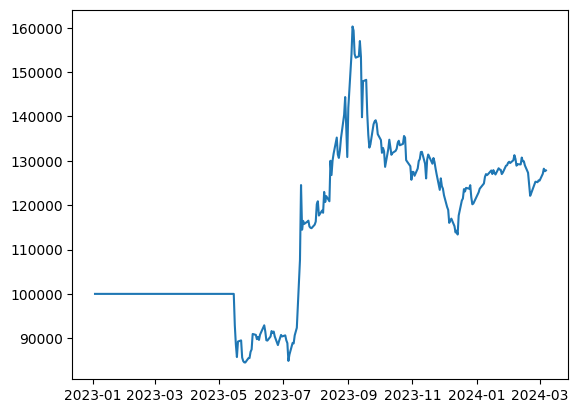

In [124]:
chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])